In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [112]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [113]:
class FullyConnected(torch.nn.Module):
    def __init__(self, n_hidden, n_layer):
        super(FullyConnected, self).__init__()
        self.hidden1 = torch.nn.Linear(1, n_hidden).double().to(device)
        torch.nn.init.xavier_uniform_(self.hidden1.weight, gain=1).to(device)
        torch.nn.init.ones_(self.hidden1.bias).to(device)

        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden).double().to(device)    # hidden layer
        torch.nn.init.xavier_uniform_(self.hidden2.weight, gain=1).to(device)
        torch.nn.init.ones_(self.hidden2.bias).to(device)

        self.predict = torch.nn.Linear(n_hidden, 1).double().to(device)   # output layer
        torch.nn.init.xavier_uniform_(self.predict.weight, gain=1).to(device)
        torch.nn.init.ones_(self.predict.bias).to(device)

        self.bn1 = torch.nn.BatchNorm1d(num_features=n_hidden).double().to(device)

        self.num_layers = n_layer
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x, train=False):
        x = self.hidden1(x)
        # x = self.bn1(x)
        x = self.tanh(x)
        # x = self.dropout(x)

        # for creating number of layers dynamically
        for _ in range(self.num_layers):
            x = self.hidden2(x)
            # x = self.bn1(x)
            x = self.tanh(x)
            # x = self.dropout(x)
        x = self.predict(x)
        return x

In [114]:
def plot_data(np_array1=None, np_array2=None, np_array3=None, savefile_name=None, labels=None):
    plt.figure(figsize=(9, 6))

    Var1X, Var1Y = np_array1[:, 0], np_array1[:, 1]
    Var2X, Var2Y = np_array2[:, 0], np_array2[:, 1]

    plt.plot(Var1X, Var1Y, label=labels[0], color="red", linestyle="dashed", marker="*", markeredgecolor="red", markerfacecolor="red", markersize=5)

    plt.plot(Var2X, Var2Y, label=labels[1], color="green", linestyle="solid", marker="p", markeredgecolor="green", markerfacecolor="green", markersize=5)
    
    plt.xlabel(labels[2])
    plt.ylabel(labels[3], labelpad=0.001)

    plt.grid(ls='--', alpha=0.5, c='#ccc')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'img/fem_nn/{savefile_name}.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()
    plt.close()

In [115]:
def sol_exata(x): return np.sin(np.pi*x)**2

In [116]:
modelo = FullyConnected(n_hidden=10, n_layer=3).to(device)

In [117]:
modelo.load_state_dict(torch.load('modelo_femnn.pt', map_location=device))

<All keys matched successfully>

In [118]:
data = torch.linspace(0, 2, 128).reshape(-1, 1).double().to(device)
u_exata = np.asarray([sol_exata(x) for x in data.detach().cpu().numpy()])

In [119]:
modelo.eval()

with torch.inference_mode():
    pred = modelo(data)

In [120]:
mse = mean_squared_error(u_exata, pred.detach().cpu().numpy())
mae = mean_absolute_error(u_exata, pred.detach().cpu().numpy())
print('MSE: ', mse)
print('MAE: ', mae)

MSE:  3.2020090532993915e-07
MAE:  0.0004121272683053733


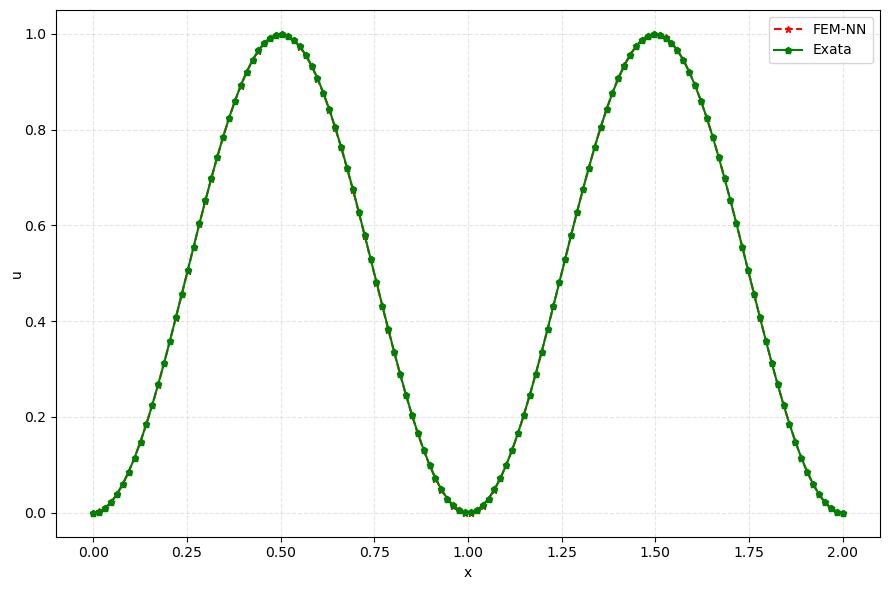

In [121]:
var1 = np.concatenate((data.detach().cpu().numpy(), pred.detach().cpu().numpy()), axis=1)
var2 = np.concatenate((data.detach().cpu().numpy(), u_exata), axis=1)

plot_data(np_array1=var1, np_array2=var2, labels=["FEM-NN", "Exata", "x", "u"])